In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as mp
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as tick
import scipy.fftpack as fft
import scipy.io.wavfile as wav
import scipy.optimize as opt
import scipy.linalg as la
import numpy.random as rd
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error as mse
import cvxpy as cvx
import IPython.display as disp
import joblib as jl
import time, h5py, os
import datetime as date
from jupyterthemes import jtplot

In [3]:
jtplot.reset()
sns.set()
sns.set_context('paper')
mp.rcParams["figure.figsize"] = (5*16/9,5)
mp.rcParams["figure.dpi"] = 100
rd.seed(314)

In [4]:
"""Implementation of the Smoothed L0 Optimisation algorithm developed by Mohimani et al, see http://ee.sharif.edu/~SLzero/ for details."""

def gaussian_F(x_i, sigma):
    """Calculate the maximisation function f_{sigma} for an element of the vector x"""
    x = np.abs(x_i)
    return x_i * np.exp(-1*x*x/(2*sigma*sigma))

Fsigma_gauss = np.vectorize(gaussian_F, otypes=[np.float_]) #Vectorize the gaussian function

def SL0(A, b, **kwargs):
    """Function that performs the SL0 algorithm given the matrix A and b, and a minimum value of sigma.
    Arguments: 
     - A: numpy matrix
     - b: numpy matrix
     - sigma_min: Float, minimum value of the approximation parameter sigma. A sensible default is 1e-12
    Optional keyword arguments:
    - FSigma: vectorized function that takes an element of a vector, and the parameter sigma, as arguments. Defaults to
    the Gaussian form used by the authors
    - L: Number of steps of the gradient ascent step, defaults to 3
    - mu_0: Gradient in the gradient ascent step, defaults to 2
    - sigma_decrease: Amount by which the approximation parameter decreases each step
    """
    #Defaults for mu_0, L, decrease factor taken from the paper
    Fsigma = kwargs.pop('Fsigma', Fsigma_gauss)
    sigma_min = kwargs.pop("sigma_min", 1e-12)
    mu_0 = kwargs.pop('mu_0', 2)
    L = kwargs.pop('L', 3)
    sdf = kwargs.pop('sigma_decrease',0.5)
    A_plus = np.linalg.pinv(A)
    x = A_plus.dot(b)
    sigma = 2*np.max(np.abs(x))
    while sigma > sigma_min:
        for i in range(L): #Do L rounds of gradient ascent
            delta = Fsigma(x, sigma)
            x -= mu_0*delta
            x -= A_plus.dot(A.dot(x) - b)
        sigma *= sdf #Sigma decrease factor value chosen b the authors
    return np.around(x, decimals=10)

def get_frequency(ft, samprate):
    return np.argmax(abs(ft))/len(ft)*samprate

In [5]:
class compsenseFromFile:
    
    def __init__(self, filename, downsample=False, downrate=None):
        self.rate, self.data = wav.read(filename)
        self.plotargs = ["k-"]
        
        if len(self.data.shape) > 1 and self.data.shape[1] > 1:
            self.data = self.data.mean(axis=1)
            
        self.N = len(self.data)
        self.dur = self.N/self.rate
        self.t = np.linspace(0, self.dur, self.N)
        self.coef = fft.fft(self.data)
        self.coefshift = fft.fftshift(self.coef)
        
        if downsample:
            self.downrate = downrate
            self.Nd = int(downrate*self.dur)
            nd = np.round(np.linspace(0, self.N-1, self.Nd)).astype(int)
            self.data = self.data[nd]
            self.t = self.t[nd]
            self.coef = fft.fft(self.data)
            self.coefshift = fft.fftshift(self.coef)
            self.rate = downrate
        else:
            self.Nd = self.N
            self.t = np.linspace(0, self.dur, self.Nd)
        
    def getDominantFrequency(coef, rate):
        return np.argmax(abs(coef))/len(coef)*rate
        
    def displayOriginal(self):
        fig = mp.figure(figsize=(5*16/9*2, 5))

        ax = fig.add_subplot(121)
        ax.plot(self.t, self.data, *self.plotargs, lw=0.4)
        ax.set_xlabel("time, s")
        ax.set_ylabel("amplitude")
        ax.set_title("original signal, $f_s = %i$Sa/s"%(self.rate))

        f = np.linspace(-self.rate/2, self.rate/2, self.Nd)
        ax = fig.add_subplot(122)
        ax.plot(f, abs(self.coefshift), *self.plotargs)
        ax.set_xlabel("frequency, Hz")
        ax.set_ylabel("density")
        ax.set_title("Frequency spectrum")

        mp.show()
        disp.Audio(self.data, rate=self.rate)
        
    def sampleCompressive(self, mode, rate):
        self.subrate = rate
        self.M = int(self.subrate*self.dur)
        
        if mode == "random":
            m = np.sort(rd.randint(0, self.Nd, self.M))
        elif mode == "subnyquist":
            m = np.round(np.linspace(0, self.Nd-1, self.M)).astype(int)
        else:
            raise ValueError("Specified mode is invalid")
        
        self.y = self.data[m]
        self.tm = self.t[m]
        self.compressedCoef = fft.fft(self.y)
        self.compressedCoefShift = fft.fftshift(self.compressedCoef)
        self.m = m
        
    def displayCompressed(self):
        fig = mp.figure(figsize=(5*16/9*2, 5))

        ax = fig.add_subplot(121)
        ax.plot(self.tm, self.y, *self.plotargs, lw=0.4)
        ax.set_xlabel("time, s")
        ax.set_ylabel("amplitude")
        ax.set_title("compressively sampled signal")

        f = np.linspace(0, self.subrate, self.M)
        ax = fig.add_subplot(122)
        ax.plot(f, abs(self.compressedCoef), *self.plotargs)
        ax.set_xlabel("frequency, Hz")
        ax.set_ylabel("density")
        ax.set_title("Frequency spectrum")

        mp.show()
        disp.Audio(self.y, rate=self.subrate)
    
    def recovery(self, method, **method_kwargs):
        d = fft.dct(np.identity(self.Nd))
        A = d[self.m]
        
        if method == "lasso":
            prob = skl.Lasso(**method_kwargs)
        elif method == "lassocv":
            prob = skl.LassoCV(**method_kwargs)
        elif method == "omp":
            prob = skl.OrthogonalMatchingPursuit(**method_kwargs)
        elif method == "sl0":
            prob = SL0(A, self.y)
            self.recoveredCoef = prob
            return
        else:
            raise ValueError("Specified method is invalid")
        
        prob.fit(A, self.y)
        self.recoveredCoef = prob.coef_
        xhat = fft.idct(self.recoveredCoef)
        xhat = np.round(xhat/self.data.max() *((2**16 - 1)//2)).astype("int16")
        self.xhat = xhat
            
    def displayRecovered(self):
        xhat = self.xhat
        #assert(str(self.data.dtype) == "int16")
        fig = mp.figure(figsize=(5*16/9*2, 5))

        ax = fig.add_subplot(121)
        ax.plot(self.t, xhat, *self.plotargs, lw=0.4)
        ax.set_xlabel("time, s")
        ax.set_ylabel("amplitude")
        ax.set_title("reconstructed signal")

        f = np.linspace(0, self.rate, self.Nd)
        ax = fig.add_subplot(122)
        ax.plot(f, abs(self.recoveredCoef), *self.plotargs)
        ax.set_xlabel("frequency, Hz")
        ax.set_ylabel("density")
        ax.set_title("Frequency spectrum")

        mp.show()
        disp.Audio(self.xhat, rate=self.rate)
        
    def get_mse(self):
        return mse(self.data, self.xhat)
    
    def get_recoveredCoefs(self):
        return self.recoveredCoef
        
    def run_all(self, mode, rate, method, **method_kwargs):
        #self.displayOriginal()
        self.sampleCompressive(mode, rate)
        #self.displayCompressed()
        self.recovery(method, **method_kwargs)
        #self.displayRecovered()

In [10]:
# notelist = ["DDhigh", "DC#", "DC", "DB", "DA#", "DA", "DG#",
#            "DG", "DF#", "DF", "DE", "DD#", "DDeq"]
notelist = ["DDeq"]
rand_iterations = 1
pcsamples = np.arange(1, 11, 1, int)

Dhi = 293.6 #Hz
Dlo = 146.8 #Hz

In [12]:
t0 = time.time()

for i,n in enumerate(notelist):
    if i == 0:
        t1 = time.time()
        hours, rem = divmod(t1-t0, 3600)
        minutes, seconds = divmod(rem, 60)
        print("{0} : Starting process".format(str(date.datetime.now())))
        print("{0} : Processing file {1}, {2:0>2}:{3:0>2}:{4:05.2f} elapsed, {5:.2f}% done".format(str(date.datetime.now()), n + ".wav", int(hours), int(minutes), seconds, 100*i/len(notelist)))
    else:
        t1 = time.time()
        hours, rem = divmod(t1-t0, 3600)
        minutes, seconds = divmod(rem, 60)
        print("{0} : Processing file {1}, {2:0>2}:{3:0>2}:{4:05.2f} elapsed, {5:.2f}% done".format(str(date.datetime.now()), n + ".wav", int(hours), int(minutes), seconds, 100*i/len(notelist)))
    
    mselist = np.zeros_like(pcsamples, float)
    stdlist = np.zeros_like(pcsamples, float)
    for j,m in enumerate(pcsamples):
        print("{0} : \t{1}% of total samples".format(str(date.datetime.now()), m))
        
        mse_iterstage = np.zeros(rand_iterations, float)
        for k in range(rand_iterations):
            print("{0} : \t\tIteration {1} of {2}".format(str(date.datetime.now()), k+1, rand_iterations))
            sig = compsenseFromFile("raw/" + n + ".wav")
            sig.run_all("random", int(len(sig.data)*m/100), "sl0")
            if k == 0:
                coeflist = np.zeros(len(sig.get_recoveredCoefs()))
            coeflist += sig.get_recoveredCoefs()
#             mse_iterstage[k] = sig.get_mse()
            
#         mselist[j] = mse_iterstage.mean()
#         stdlist[j] = mse_iterstage.std()
        coeflist /= rand_iterations
        np.save("coef/coeflist_" + str(m) + "pcent_" + n + "_SL0.npy", coeflist)
    
#     np.save("mse/mselist_" + notelist[i] + "_.npy", mselist)
#     np.save("std/stdlist_" + notelist[i] + ".npy", stdlist)

t1 = time.time()
hours, rem = divmod(t1-t0, 3600)
minutes, seconds = divmod(rem, 60)
print("{0} : Process finished, {1:0>2}:{2:0>2}:{3:05.2f} elapsed total".format(str(date.datetime.now()), int(hours), int(minutes), seconds))

2019-05-15 23:48:03.373024 : Starting process
2019-05-15 23:48:03.373024 : Processing file DDeq.wav, 00:00:00.00 elapsed, 0.00% done
2019-05-15 23:48:03.373024 : 	1% of total samples
2019-05-15 23:48:03.373024 : 		Iteration 1 of 1
2019-05-15 23:48:39.424712 : 	2% of total samples
2019-05-15 23:48:39.424712 : 		Iteration 1 of 1
2019-05-15 23:49:13.841093 : 	3% of total samples
2019-05-15 23:49:13.841093 : 		Iteration 1 of 1
2019-05-15 23:50:22.909016 : 	4% of total samples
2019-05-15 23:50:22.909016 : 		Iteration 1 of 1
2019-05-15 23:51:33.783881 : 	5% of total samples
2019-05-15 23:51:33.783881 : 		Iteration 1 of 1


LinAlgError: SVD did not converge

In [11]:
mselist = np.load("mse/mselist_DDhigh_.npy")

mseall = np.zeros((len(notelist), len(pcsamples), len(mselist)), float)
stdall = np.zeros_like(mseall)

for i,n in enumerate(notelist):
    mseall[i,:,:] = np.load("mse/mselist_" + n + "_.npy")
    stdall[i,:,:] = np.load("std/stdlist_" + n + ".npy")
    
semidiff = np.zeros_like(np.arange(0,13, 1, float))
for n in range(len(semidiff)):
    semidiff[n] = np.round(Dhi - Dhi*2**(-n/12), 2)

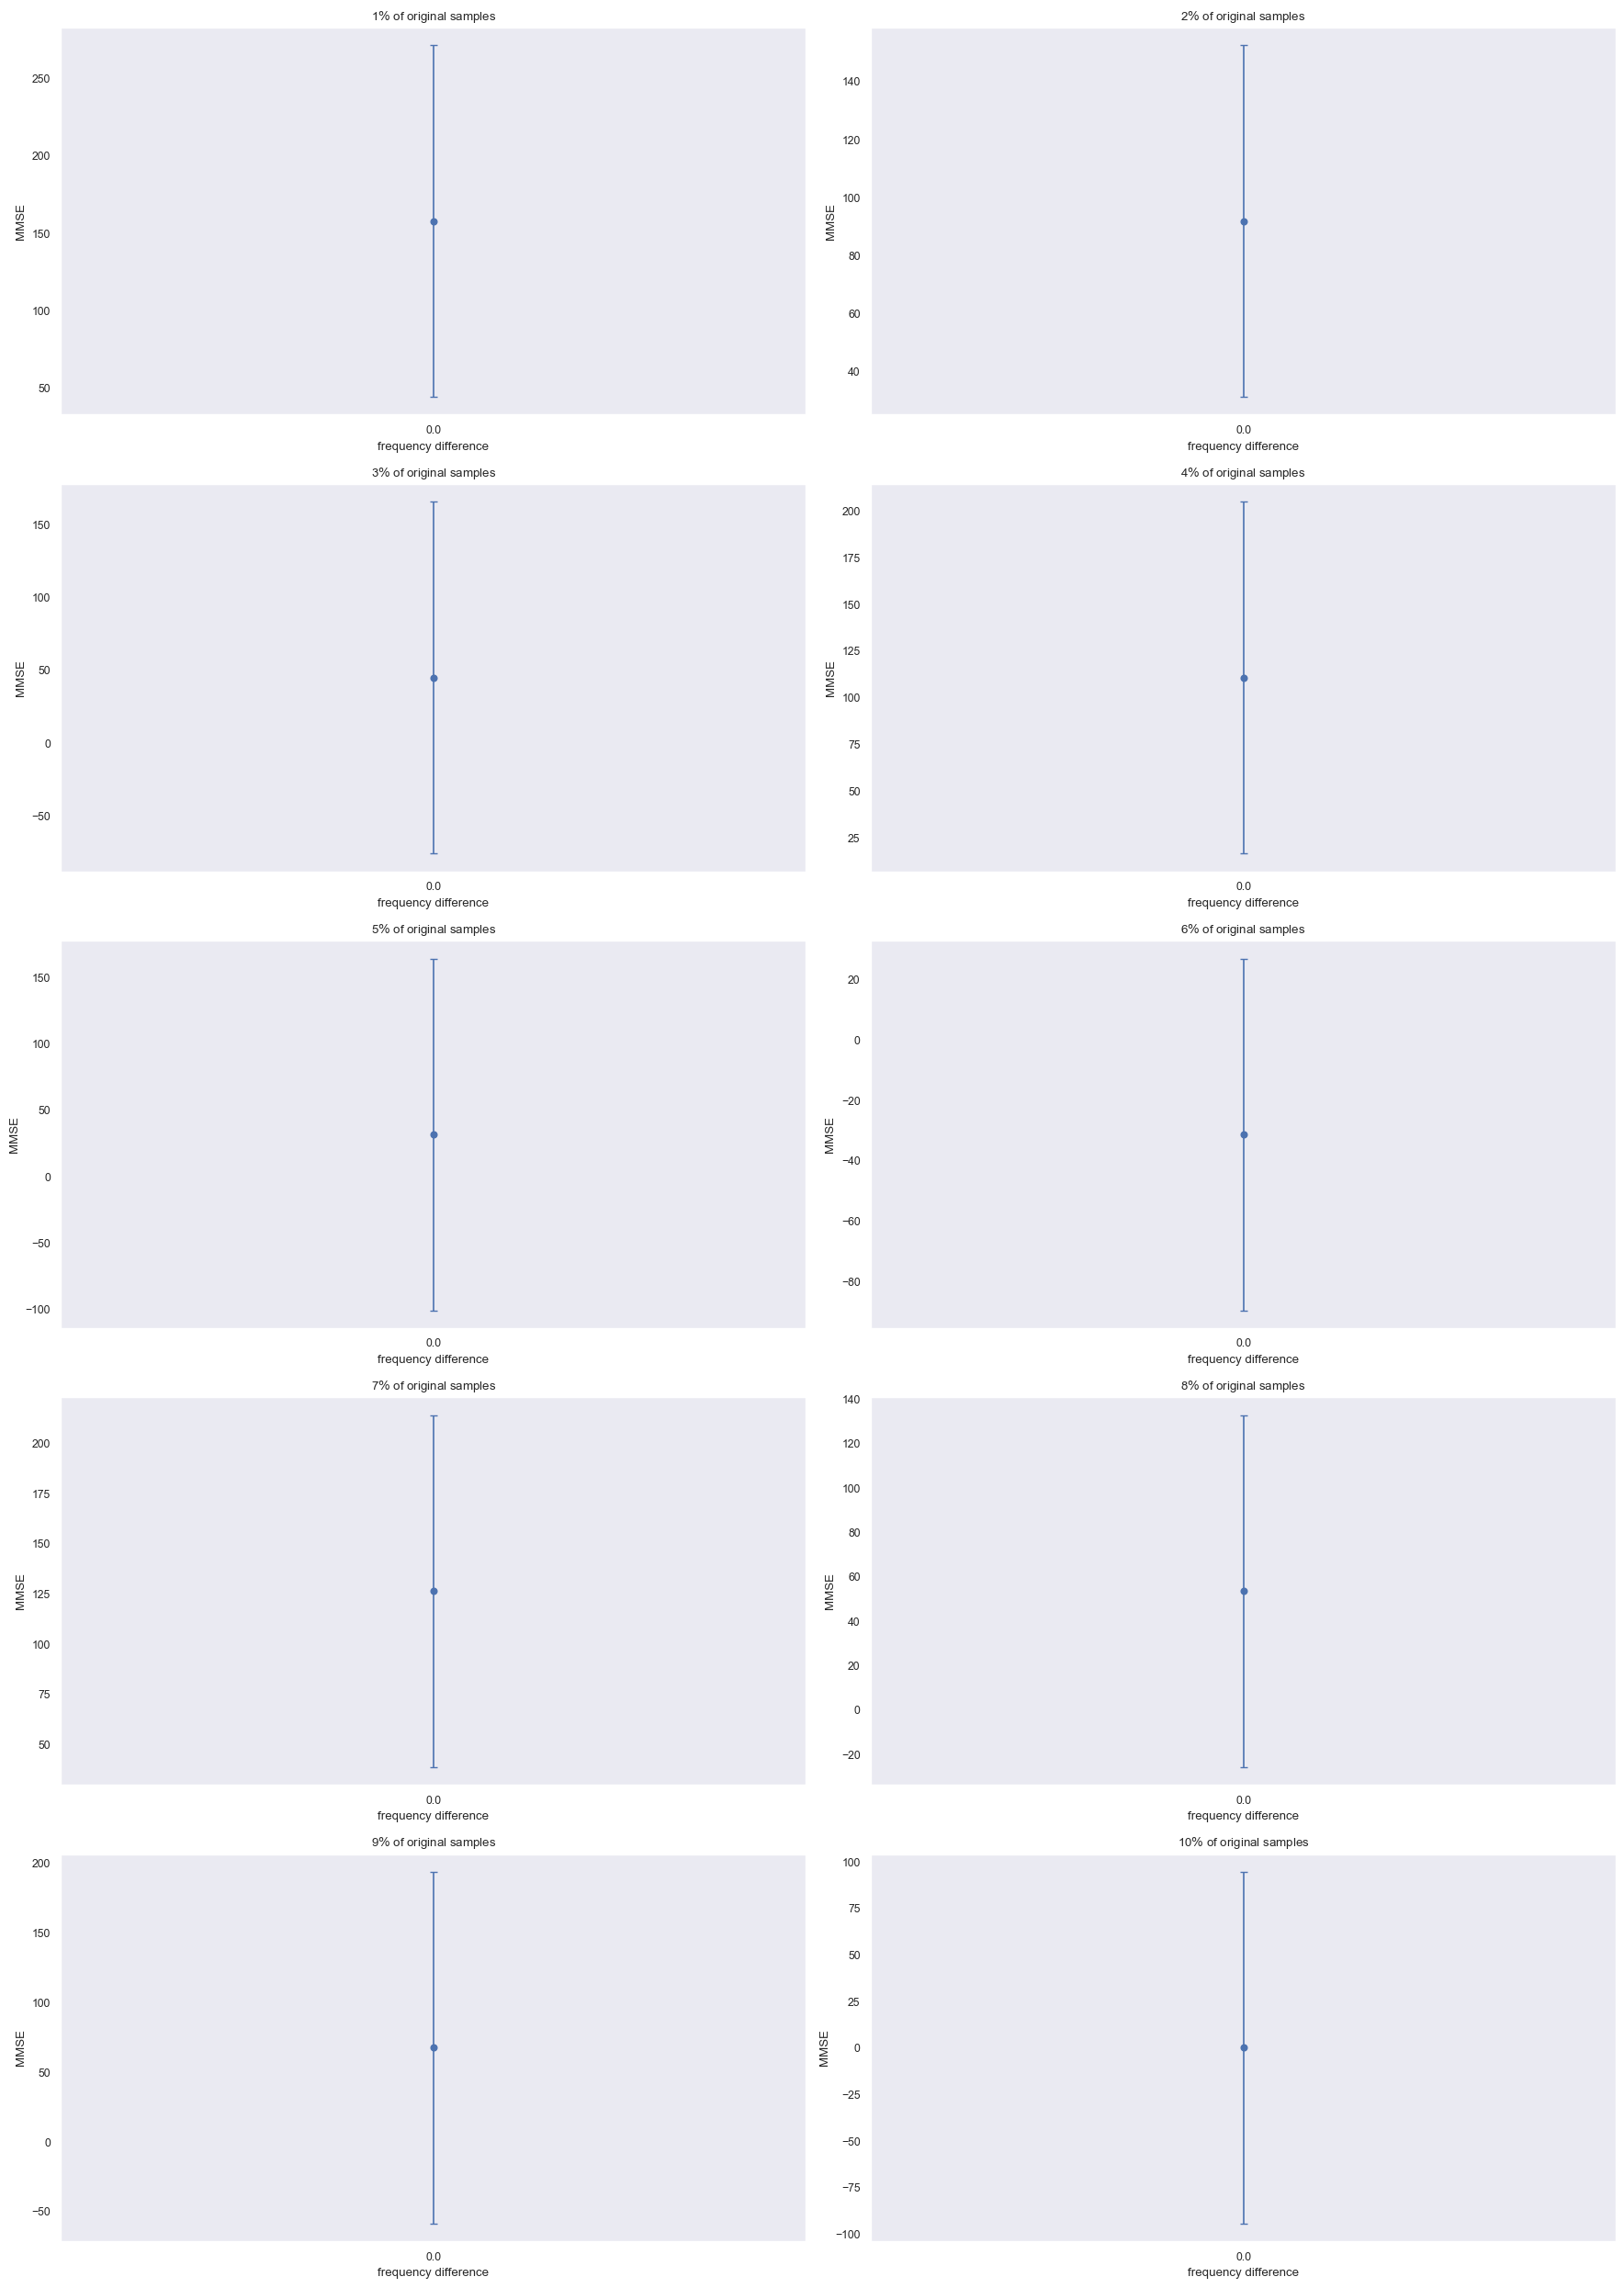

In [14]:
fig = mp.figure(figsize=(5*16/9*2, 5*5))

for i in range(len(pcsamples)):
    ax = fig.add_subplot(5,2,i+1)
    ax.errorbar(range(len(notelist)), mseall[::-1,0,i], stdall[::-1,0,i], None, "o", capsize=3)
    ax.xaxis.set_major_locator(tick.FixedLocator(range(len(notelist))))
    ax.xaxis.set_major_formatter(tick.FixedFormatter(semidiff))
    ax.set_xlabel("frequency difference")
    ax.set_ylabel("MMSE")
    ax.set_title(str(i+1) + r"$\%$ of original samples")
    ax.grid()

# mp.suptitle("LASSO recovery, average over %i iterations"%rand_iterations)
mp.tight_layout()
# mp.savefig("mse_vs_semidiff.png", dpi=300, bbox_inches="tight", transparent=True)
mp.show()

In [15]:
fig = mp.figure(figsize=(5*16/9*2, 5*7.75))

for i in range(13, 0, -1):
    ax = fig.add_subplot(7,2,i)
    ax.errorbar(pcsamples, mseall[i-1,0,:], stdall[i-1,0,:], None, "o", capsize=3)
    ax.xaxis.set_major_locator(tick.FixedLocator(range(len(pcsamples)+1)))
    ax.xaxis.set_major_formatter(tick.FixedFormatter(np.arange(11)))
    ax.set_xlabel("percentage of total samples")
    ax.set_ylabel("MMSE")
    ax.set_title("%.2f Hz difference"%(semidiff[i-1]))
    ax.grid()

# mp.suptitle("LASSO recovery, average over %i iterations"%rand_iterations)
# mp.savefig("mse_vs_pcsamples.png", dpi=300, bbox_inches="tight", transparent=True)
mp.show()

IndexError: index 12 is out of bounds for axis 0 with size 1

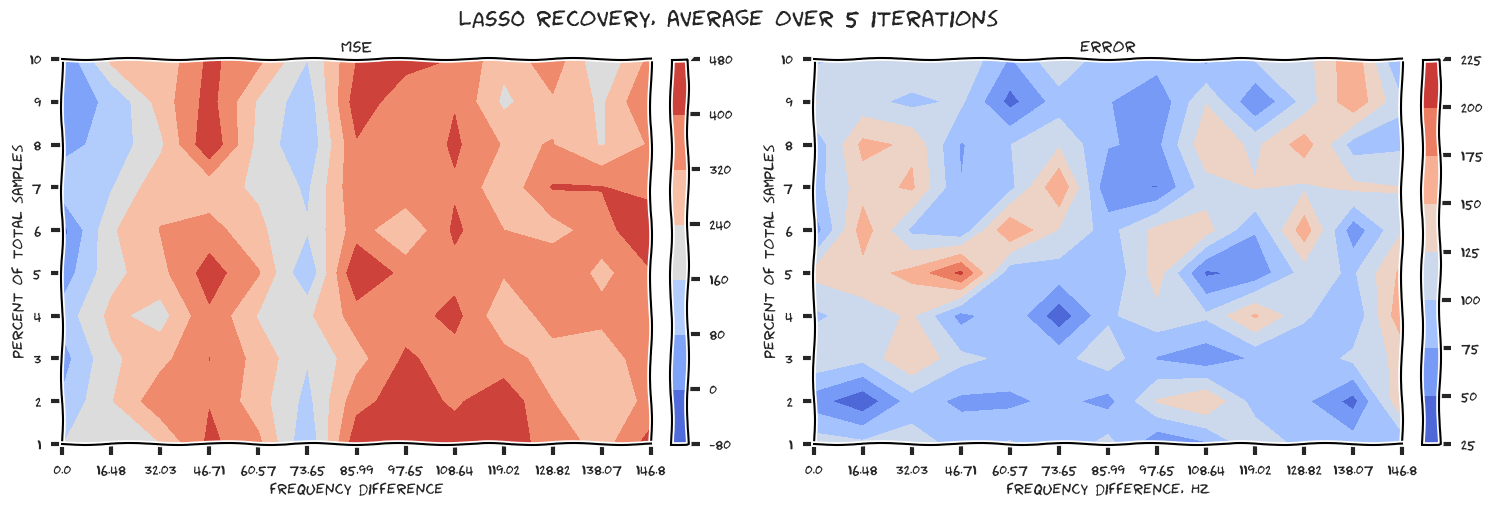

In [12]:
fig = mp.figure(figsize=(5*16/9*2, 5))

ax1 = fig.add_subplot(121)
X,Y = np.meshgrid(range(len(notelist)), pcsamples)
im1 = ax1.contourf(X, Y, mseall.T[:,0,::-1], cmap="coolwarm")
ax1.xaxis.set_major_locator(tick.FixedLocator(range(len(notelist))))
ax1.xaxis.set_major_formatter(tick.FixedFormatter(semidiff))
ax1.set_xlabel("frequency difference")
ax1.set_ylabel("percent of total samples")
ax1.set_title("MSE")
ax1.grid(False)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="3%", pad=0.2)
fig.colorbar(im1, cax=cax, orientation="vertical")


ax2 = fig.add_subplot(122)
im2 = ax2.contourf(X[::-1], Y, stdall.T[:,0,::-1], cmap="coolwarm")
ax2.xaxis.set_major_locator(tick.FixedLocator(range(len(notelist))))
ax2.xaxis.set_major_formatter(tick.FixedFormatter(semidiff))
ax2.set_xticks(range(len(notelist)), range(12, -1, -1))
ax2.set_xlabel("frequency difference, Hz")
ax2.set_ylabel("percent of total samples")
ax2.set_title("error")
ax2.grid(False)

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="3%", pad=0.2)
fig.colorbar(im2, cax=cax, orientation="vertical")

mp.suptitle("LASSO recovery, average over %i iterations"%rand_iterations)
# mp.savefig("mse+sdom.png", dpi=300, bbox_inches="tight", transparent=True)
mp.show()

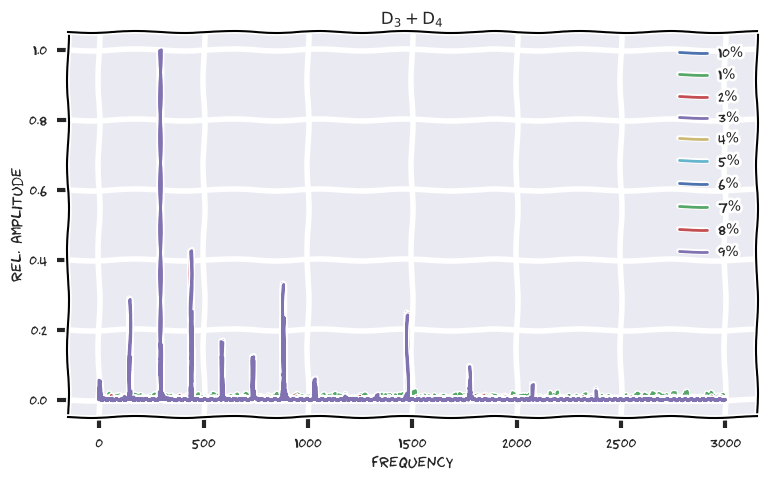

In [28]:
rate = 6000
N = len(coef)
f = np.linspace(0, rate/2, N)

for _, __, files in os.walk("./coef"):
    for file in files:
        if file.endswith("_DDhigh.npy"):
            coef = np.load("./coef/" + file)
            mp.plot(f, abs(coef)/abs(coef).max(), label=file[9] + r"$\%$") if file[10] != "0" \
            else mp.plot(f, abs(coef)/abs(coef).max(), label=file[9:11] + r"$\%$")

mp.grid(True)
mp.xlabel("frequency")
mp.ylabel("rel. amplitude")
mp.title(r"$\mathrm{D_3 + D_4}$")
mp.legend()
mp.show()

In [158]:
rate = 6000
N = len(coef)
f = np.linspace(0, rate/2, N)
cmax = []
coeflist = np.zeros((10, N), float)
count = 0

for _, __, files in os.walk("./coef"):
    for file in files:
        if file.endswith("_DDhigh.npy"):
            coef = np.load("./coef/" + file)
            coeflist[count] = coef
            cmax.append(abs(coef).max())
            count += 1

cmax = np.array(cmax)
coeflist = abs(np.roll(coeflist, -1, axis=0))

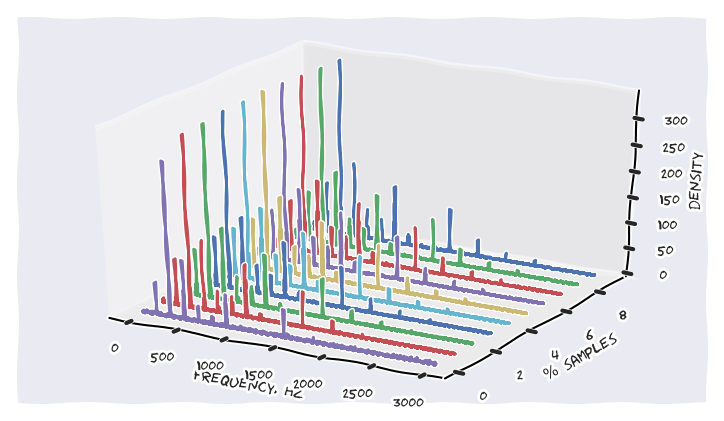

In [169]:
fig = mp.figure()

ax = fig.add_subplot(111, projection="3d")
for i in range(9, -1, -1):
    ax.plot(f, np.ones(len(f))*i, coeflist[i])
ax.set_xlabel("frequency, Hz")
ax.set_ylabel("$\%$ samples")
ax.set_zlabel("density")

mp.show()

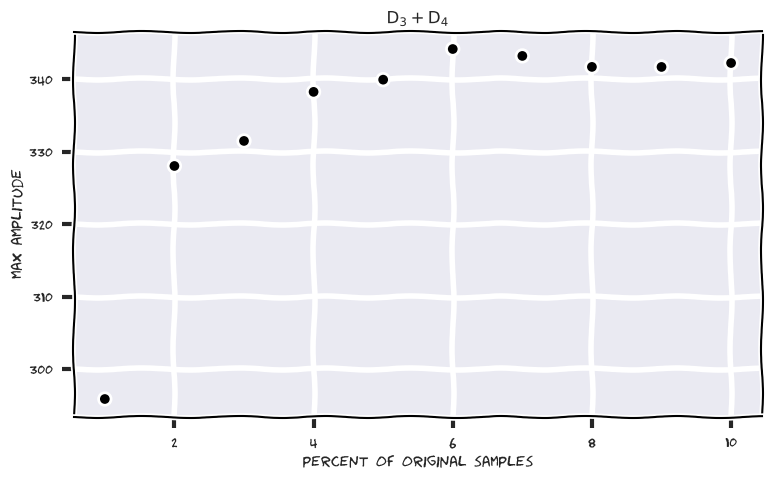

In [155]:
mp.plot(range(1,11), np.roll(cmax, -1), "ko")
mp.grid()
mp.xlabel("percent of original samples")
mp.ylabel("max amplitude")
mp.title(r"$\mathrm{D_3 + D_4}$")
mp.show()